# **Advanced Machine Learning, Problem 7:**

### Programming Assignement.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as lg

## **Data processing**

In [ ]:
import pandas as pd 

data_all = pd.read_csv("zoo.csv") 

data = pd.get_dummies(data_all, columns = ['legs'])

types = data.pop('types')
names = data.pop('name')

## **PCA**

In [ ]:
from sklearn.preprocessing import StandardScaler

# Separating out the features
x = np.array(data)

# Standardizing the features
x = StandardScaler().fit_transform(x)

In [ ]:
# PCA with python

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

principalDf.insert(0, "Name", names, True)
principalDf.insert(3, "Types", types, True)


In [ ]:
# My PCA using svd

u, s, vt = np.linalg.svd(x, full_matrices=True)
v_2 = np.transpose(vt)[:,:2]
pc = np.dot(x, v_2)
myprincipalDf = pd.DataFrame(data = pc
             , columns = ['principal component 1', 'principal component 2'])

myprincipalDf.insert(0, "Name", names, True)
myprincipalDf.insert(3, "Types", types, True)

Let's plot now.

In [ ]:
def plot_results(df, method, feature1, feature2):
  fig = plt.figure(figsize = (8,8))
  ax = fig.add_subplot(1,1,1) 

  ax.set_xlabel(feature1, fontsize = 15)
  ax.set_ylabel(feature2, fontsize = 15)
  ax.set_title('2 component '+ method + ' for our animals data', fontsize = 20)

  types_v = [e for e in range(1,8)]
  colors = ['r', 'g', 'b', 'brown', 'yellow', 'black', 'pink']

  for t, color in zip(types_v,colors):
      indicesToKeep = df['Types'] == t
      ax.scatter(df.loc[indicesToKeep, feature1]
                , df.loc[indicesToKeep, feature2]
                , c = color
                , s = 100)
      
  # for i in range(101):
  #     ax.annotate(names[i], (df[feature1][i], df[feature2][i]))

  ax.legend(types_v)
  ax.grid()


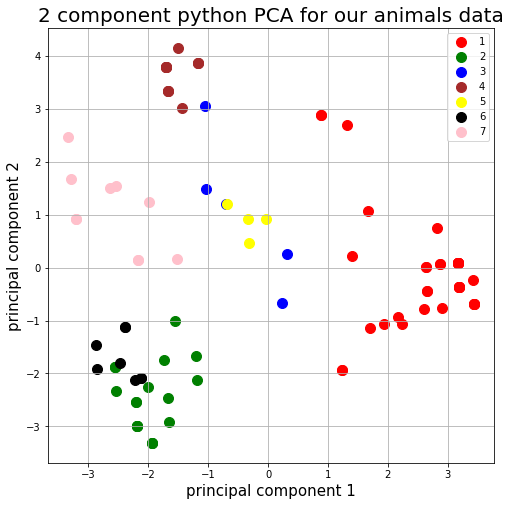

In [ ]:
plot_results(principalDf, 'python PCA', 'principal component 1', 'principal component 2')

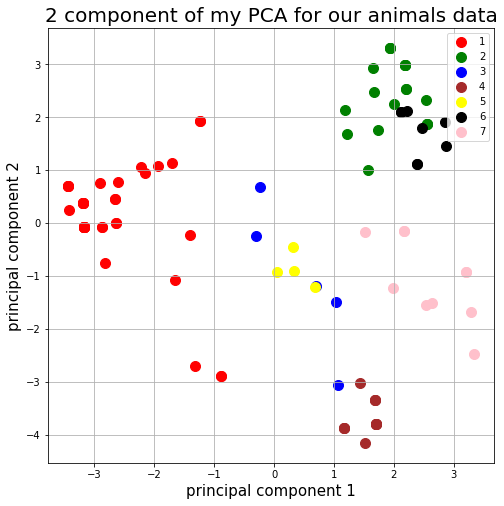

In [ ]:
plot_results(myprincipalDf, 'of my PCA', 'principal component 1', 'principal component 2')

In [ ]:
#Reconstruction error of PCA

X_projected = pca.inverse_transform(principalComponents)
error_pca = ((x - X_projected) ** 2).mean()

print("Reconstruction error of PCA:", error_pca)

Reconstruction error of PCA: 0.5477519861535181


# **MDS**

Let's construct the Gram matrix S (similarity matrix)

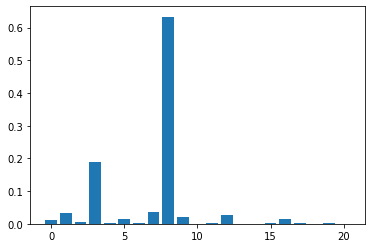

In [ ]:
# Let's explore a bit the features importance here
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

model = RandomForestRegressor()

model.fit(data, types)
importance = model.feature_importances_
 
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [ ]:
# we will delete the features that have 0 importance, i.e features 13, 14, 18
features = list(data.columns)

copy_data = data.copy()

for i in [13, 14, 18]:
   data.pop(features[i])

new_data = data
data = copy_data

In [ ]:
from scipy.spatial.distance import euclidean, pdist, squareform

def euclidian_func(u, v):
    return euclidean(u,v)

dists = pdist(new_data, euclidian_func)
distance_matrix = squareform(dists)
D = np.array(distance_matrix)


In [ ]:
def MDS(D, k):
  n = len(D)
  ones = np.ones((n, n))

  S = - (1/2) * (D - (1/n) * np.dot(D, ones) - (1/n) * np.dot(ones, D) + (1/n**2) * np.dot(ones, np.dot(D, ones)))
  eigenvalues, eigenvectors = lg.eig(S)
  Lambda = np.diag(np.abs(np.real(eigenvalues)))
  U = np.real(eigenvectors)

  I = np.eye(k, n)
  Lambda_sqrt = np.sqrt(Lambda)
  U_transpose = np.transpose(U)

  return np.transpose(np.dot(I, np.dot(Lambda_sqrt, U_transpose)))



Let's plot.

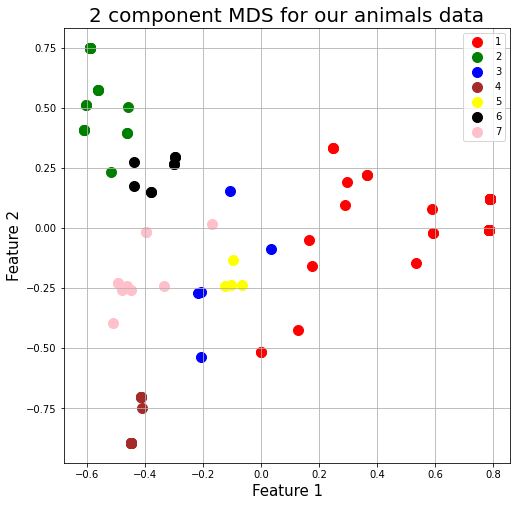

In [ ]:
X_mds = MDS(D, 2)

mds_df = pd.DataFrame(data = X_mds
             , columns = ['Feature 1', 'Feature 2'])
mds_df.insert(0, "Name", names, True)
mds_df.insert(3, "Types", types, True)

plot_results(mds_df, 'MDS', 'Feature 1', 'Feature 2')

# **Isomap**

In [ ]:
# Function to check whether the graph is connected or not.

def dfs(G , vertice, visited):
  visited[vertice] = True
  n = len(G)
  for v in range(n):
    if G[vertice, v] != 0  and (not visited[v]): 
      dfs(G, v, visited)

def isConnected(G):
  visited = {}
  n = len(G)
  for i in range(n):
    visited[i] = False
  dfs(G, 0, visited)
  for i in range(n):
    if not visited[i]:
      return False
  
  return True

Is the graph connected: True


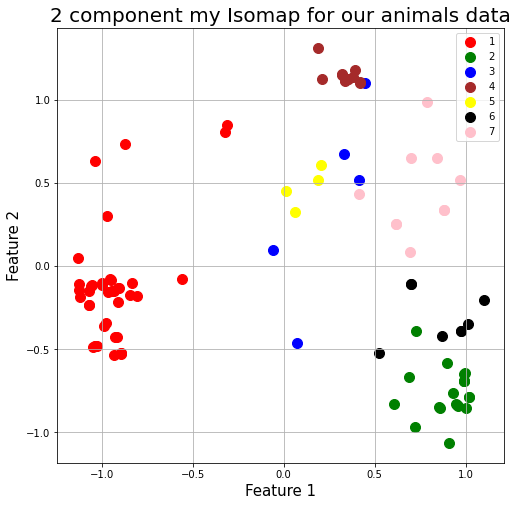

In [ ]:
from sklearn.neighbors import kneighbors_graph
from sklearn.utils.graph_shortest_path import graph_shortest_path

G = kneighbors_graph(np.array(data), 16, mode='distance')

# Check if connected
print("Is the graph connected:", isConnected(G.toarray()))

# Distance matrix
D_iso = graph_shortest_path(G, directed = False , method='FW')

#Constructing the embedding
X_iso = MDS(D_iso, 2)

#Plot
iso_df = pd.DataFrame(data = X_iso
             , columns = ['Feature 1', 'Feature 2'])
iso_df.insert(0, "Name", names, True)
iso_df.insert(3, "Types", types, True)

plot_results(iso_df, 'my Isomap', 'Feature 1', 'Feature 2')

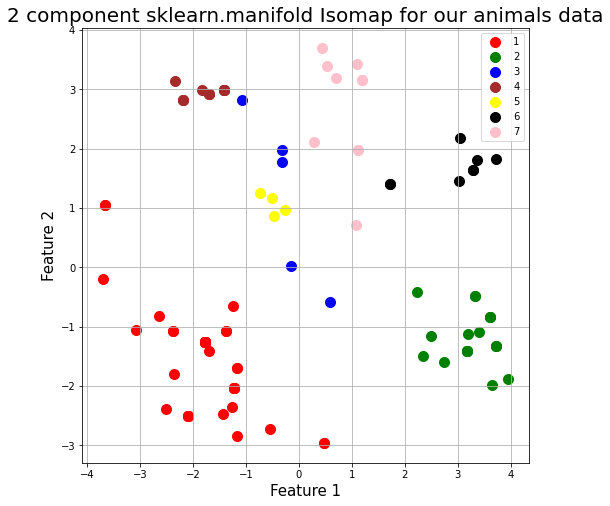

In [ ]:
# Isomap Python to compare the results.

from sklearn.manifold import Isomap

embedding = Isomap(n_components=2, n_neighbors =16 , neighbors_algorithm = 'brute')
X_transformed = embedding.fit_transform(data)

#Plot
iso = pd.DataFrame(data = X_transformed
             , columns = ['Feature 1', 'Feature 2'])
iso.insert(0, "Name", names, True)
iso.insert(3, "Types", types, True)

plot_results(iso, 'sklearn.manifold Isomap', 'Feature 1', 'Feature 2')

In [ ]:
# Recontruction error of Isomap
error_isomap = embedding.reconstruction_error()

print("Reconstruction error of Isomap:", error_isomap)

Reconstruction error of Isomap: 1.7219265308384222


# **Methods Comparison**

In [ ]:
n = 16

G = kneighbors_graph(np.array(data), n, mode='connectivity').toarray()
G_isomap = kneighbors_graph(np.array(X_iso), n, mode='connectivity').toarray()
G_pca = kneighbors_graph(np.array(principalComponents), n, mode='connectivity').toarray()

# Computes normalized sum of number of identical neighbors between the original data embedding and the method embedding
def compute(G, Gm, j):
  c = 0
  for i in range(101):
    if G[j,:][i] == 1 and G[j,:][i] == Gm[1,:][i]:
      c += 1
  return c/101

s_pca = 0
s_iso = 0

for i in range(101):
  s_pca += compute(G, G_pca, i)
  s_iso += compute(G, G_isomap, i)

print("Neighbors similarity between data and PCA embedding:", s_pca)
print("Neighbors similarity between data and Isomap embedding:", s_iso)

Neighbors similarity between data and PCA embedding: 3.7029702970297054
Neighbors similarity between data and Isomap embedding: 2.2772277227722784
